# Table of contents

[Supervised - basic models](./supervised_basic.ipynb)

[Supervised - RNN models](./supervised_rnn.ipynb)

[Unsupervised - Word2Vec](./unsupervised_w2v.ipynb)

[Unsupervised - Dimensionality Reduction](./unsupervised_dim.ipynb)

[Unsupervised - LDA](./unsupervised_LDA.ipynb)

[Performance Evaluation](./evaluation.ipynb)

In [6]:
# Suppress all warnings
import warnings
warnings.filterwarnings('ignore')


import numpy as np
import pandas as pd

import re
import random

from collections import Counter, defaultdict

from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import LatentDirichletAllocation

from sklearn.cluster import KMeans
from sklearn import metrics

from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import plot_roc_curve

from tqdm import tqdm
import pickle

import gensim
from gensim.models.word2vec import Word2Vec
from collections import Counter
from nltk.tokenize import sent_tokenize, word_tokenize
from gensim.test.utils import datapath

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer


from preprocess_helper import preprocess_helper
from evaluation_helper import evaluation_helper

import time

RANDOM_SEED = 42

In [2]:
preprocessor = preprocess_helper('data/WikiLarge_Train.csv')
# X, y = preprocessor.process_with_tokenization()

train_df = preprocessor.get_df()

train_df['length']=train_df['original_text'].str.split().str.len()
train_df.sample(10)

,original_text,label,length
230840,Rasputin was buried with an icon signed on the...,0,19
380714,The Commander - The Duke of Aosta - gave his p...,0,32
3548,1970 & ndash ; Tonga gains independence from t...,1,12
195229,"Joaquín Rodrigo Vidre , 1st Marquess of the Ga...",1,38
141084,"About four weeks later , on April 17 , he laun...",1,23
169894,"During 1999 , her record company , Atlantic Re...",1,31
368448,The basic conjugative plasmid is the F-plasmid...,0,11
219343,Other pages,0,2
288294,The new name -LRB- darmstadtium -RRB- was give...,0,19
143971,Golden Balls is a British daytime game show on...,1,18


In [3]:
X=train_df['original_text']
y=train_df['label']
    
X_train, X_dev, y_train, y_dev = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

print('training data labels:\n', y_train.value_counts(),'\n')
print('dev data labels:\n', y_dev.value_counts())

training data labels:
 0    166835
1    166579
Name: label, dtype: int64 

dev data labels:
 1    41805
0    41549
Name: label, dtype: int64


In [4]:
%%time

min_df=50
ngram_range=(1,3)

#tfidf_vectorizer = TfidfVectorizer(stop_words=None, lowercase=False,  
#                                     min_df=min_df, ngram_range=ngram_range).fit(X_train)
count_vectorizer = CountVectorizer(stop_words=None, lowercase=False,  
                                     min_df=min_df, ngram_range=ngram_range).fit(X_train)

#tfidf_documents = tfidf_vectorizer.transform(X_train)
#tfidf_feature_names = tfidf_vectorizer.get_feature_names()

count_documents = count_vectorizer.transform(X_train)
count_feature_names = count_vectorizer.get_feature_names()

Wall time: 32.2 s


In [5]:
#print(tfidf_documents.shape)
print(count_documents.shape)

(333414, 23967)


In [ ]:
n_topics = 50


lda = LatentDirichletAllocation(n_components = n_topics, random_state=RANDOM_SEED)
lda.fit(count_documents)
topic_models = lda.components_
print(topic_models.shape)

In [ ]:
num_top_words = 50

def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        term_list = [feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
        print("topic %d:" % (topic_idx), term_list, '\n')


display_topics(lda, count_feature_names, num_top_words)

In [ ]:
print("Perplexity: ", lda.perplexity(count_documents))

In [ ]:
%%time

from sklearn.model_selection import GridSearchCV

search_params = {'n_components': [50]}
lda = LatentDirichletAllocation()

lda_model = GridSearchCV(lda, param_grid=search_params)
lda_model.fit(count_documents)

print('done')

In [ ]:
lda_model.best_estimator_

In [21]:
best_lda_model = lda_model.best_estimator_
print("Best Model's Params: ",lda_model.best_params_)
print("Best Log Likelihood Score: ", lda_model.best_score_)
print("Model Perplexity: ", best_lda_model.perplexity(count_documents))

Best Model's Params:  {'n_components': 50}
Best Log Likelihood Score:  -12648798.316582104
Model Perplexity:  1592.0313716350888


In [23]:
%%time

from sklearn.model_selection import GridSearchCV

search_params = {'n_components': [75, 100]}
lda = LatentDirichletAllocation()

lda_model = GridSearchCV(lda, param_grid=search_params)
lda_model.fit(count_documents)

print('done')

done
Wall time: 4h 59min 11s


In [24]:
best_lda_model = lda_model.best_estimator_
print("Best Model's Params: ",lda_model.best_params_)
print("Best Log Likelihood Score: ", lda_model.best_score_)
print("Model Perplexity: ", best_lda_model.perplexity(count_documents))

Best Model's Params:  {'n_components': 75}
Best Log Likelihood Score:  -12685358.361814748
Model Perplexity:  1596.6367492686757


In [33]:
gridsearch_result=pd.DataFrame(lda_model.cv_results_)
gridsearch_result

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_components,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1425.153256,352.527852,28.951103,10.840340,75,{'n_components': 75},-1.270855e+07,-1.273973e+07,-1.268855e+07,-1.262085e+07,-1.266911e+07,-1.268536e+07,39824.280198,1
1,1753.748200,350.604823,28.683421,8.482009,100,{'n_components': 100},-1.275428e+07,-1.280958e+07,-1.275123e+07,-1.268268e+07,-1.270977e+07,-1.274151e+07,43263.166223,2


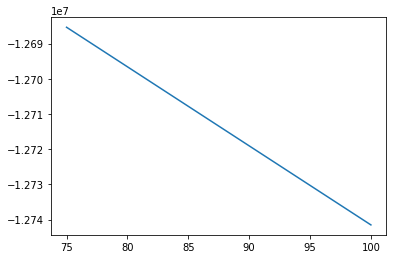

In [35]:
import matplotlib.pyplot as plt
plt.plot(gridsearch_result['param_n_components'],gridsearch_result['mean_test_score'] )

In [36]:
lda_model.cv_results_

{'mean_fit_time': array([1425.15325632, 1753.74820004]),
 'std_fit_time': array([352.52785177, 350.60482266]),
 'mean_score_time': array([28.95110288, 28.68342085]),
 'std_score_time': array([10.84033972,  8.48200871]),
 'param_n_components': masked_array(data=[75, 100],
              mask=[False, False],
        fill_value='?',
             dtype=object),
 'params': [{'n_components': 75}, {'n_components': 100}],
 'split0_test_score': array([-12708553.38579456, -12754277.3949204 ]),
 'split1_test_score': array([-12739733.21028326, -12809577.7087961 ]),
 'split2_test_score': array([-12688545.89728876, -12751231.36553613]),
 'split3_test_score': array([-12620852.97829118, -12682684.98810352]),
 'split4_test_score': array([-12669106.33741598, -12709770.41201981]),
 'mean_test_score': array([-12685358.36181475, -12741508.37387519]),
 'std_test_score': array([39824.28019783, 43263.16622311]),
 'rank_test_score': array([1, 2])}

In [37]:
display_topics(best_lda_model, count_feature_names, num_top_words)

topic 0: ['the', 'is', 'of', 'is the', 'city', 'of the', 'and', 'in', 'largest', 'capital', 'It', 'It is', 'the city', 'The', 'in the', 'located', 'city of', 'the largest', 'the capital', 'It is the'] 

topic 1: ['the', 'of', 'of the', 'and', 'in', 'Roman', 'in the', 'The', 'Empire', 'was', 'and the', 'political', 'by', 'Catholic', 'party', 'Soviet', 'year', 'Party', 'Indian', 'the Roman'] 

topic 2: ['the', 'and', 'of', 'from', 'its', 'original', 'new', 'on', 'by', 'from the', 'that', 'The', 'their', 'were', 'are', 'all', 'to', 'every', 'the original', 'own'] 

topic 3: ['the', 'album', 'band', 'The', 'by', 'song', 'released', 'is', 'rock', 'single', 'third', 'second', 'from', 'was', 'version', 'of', 'and', 'to', 'metal', 'is the'] 

topic 4: ['are', 'in', 'There', 'is', 'city', 'County', 'is city', 'city in', 'is city in', 'There are', 'different', 'States', 'United States', 'United', 'types', 'are the', 'types of', 'Wrestling', 'There is', 'currently'] 

topic 5: ['in', 'in the', 't

In [38]:
%%time

from sklearn.model_selection import GridSearchCV

search_params = {'n_components': [10, 50, 75, 100]}
lda = LatentDirichletAllocation()

lda_model = GridSearchCV(lda, param_grid=search_params)
lda_model.fit(count_documents)

print('done')

done
Wall time: 10h 47min 14s


In [39]:
gridsearch_result=pd.DataFrame(lda_model.cv_results_)
gridsearch_result

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_components,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1479.754498,332.194216,26.482786,5.437500,10,{'n_components': 10},-1.275292e+07,-1.275927e+07,-1.278050e+07,-1.267929e+07,-1.274839e+07,-1.274408e+07,34209.407109,4
1,1899.927456,126.179122,37.027969,8.091931,50,{'n_components': 50},-1.264390e+07,-1.269140e+07,-1.266836e+07,-1.259227e+07,-1.264435e+07,-1.264806e+07,32968.104401,1
2,1859.553633,27.711933,33.762890,0.688425,75,{'n_components': 75},-1.271610e+07,-1.273232e+07,-1.269287e+07,-1.262790e+07,-1.265067e+07,-1.268397e+07,39248.228988,2
3,1953.247913,17.585531,35.678870,1.198123,100,{'n_components': 100},-1.274254e+07,-1.278286e+07,-1.275668e+07,-1.268850e+07,-1.273649e+07,-1.274141e+07,30905.928192,3


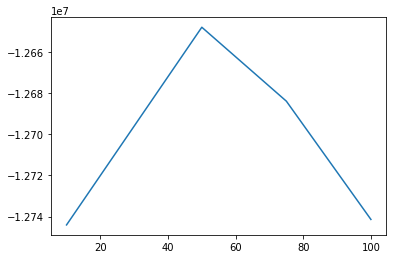

In [40]:
plt.plot(gridsearch_result['param_n_components'],gridsearch_result['mean_test_score'] )